# detecting polynomial classes from noisy data

The goal of this notebook is to interpret data in an x-y plane as a greyscale image. I want to use compare traditional MLPs with CNNs to classify unseen data and also check what happens if we confront the network with an unseen category of data. We go up to polynomials of degree 5 and randomly dice they coefficients. This can produce data that is pretty diverse.

## Training Data

The following function uses numpy to generate the data set. We make the output ndarray's shape configurable, but will stick with a 64x64 shaped plane that spans $x=(-32,32]$ or something alike.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def syn_image(x, values, yrange = None, shape = (32,32), value_span = (-1,1)):
    
    if type(yrange) == type(None):
        yrange = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
        
    current = np.zeros(shape)
    for ix in range(len(x)):
        yval = values[ix]
        xval = x[ix]
        if yval >= value_span[0] and yval <= value_span[-1]:
            yidx = len(x) -1 - np.searchsorted(yrange, yval, side="left")
            current[yidx,len(x) -1 - ix] = 1
            
    return current

def polynomials_as_images(size, max_degree, shape = (32,32), value_span = (-1,1), seed = 1, smear_sd = None):
    
    if seed:
        np.random.seed(seed)
        
    size = int(size)
    x = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[-1])
    y = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
    
    data   = np.zeros((size,int(shape[0]),int(shape[1])),
                       dtype=np.uint8)
    labels = np.random.randint(low=1,high=max_degree+1,size=size)
    
    for i in range(size):
        deg = labels[i]
        c   = np.random.random_sample(deg)
        #print(c)
        #print(x)
        values   = np.polynomial.polynomial.polyval(x,c)
        if smear_sd:
            smear_by = np.random.normal(1.,smear_sd,size=values.size)
            values = values*smear_by
        current = syn_image(x,values,y,shape,value_span)
            
        data[i,] = current
     
    return data, labels

In [135]:
train, labs = polynomials_as_images(20000,5,smear_sd=None)


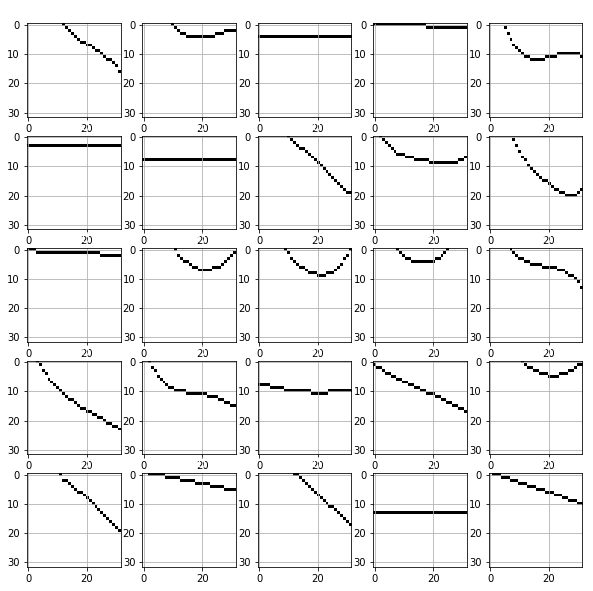

In [136]:
#nicer plots with axis labels etc
xticks = np.linspace(start=1, stop=-1,num=3)
yticks = np.linspace(start=1, stop=-1,num=3)

plt.figure(figsize=(10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    #plt.xticks([])
    #plt.yticks([])
    plt.grid(True)
    plt.imshow(train[i], cmap=plt.cm.binary)
    #ax.xlabel("pol({0})".format(labs[i]),color='white')
    ax.set_title("pol({0})".format(labs[i]),color='white')

In [146]:
#MLP comes here with non-linearity
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten

labels = to_categorical(labs)
print(labels.shape)

model = Sequential()
model.add(Flatten(input_shape=(32,32)))
model.add(Dense(64, activation='relu'))#all to all relation ship in first hidden layer
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

(20000, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_33 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 64)                65600     
_________________________________________________________________
dropout_100 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_101 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_102 (Dropout)        (None, 64)                0         

In [147]:
hist = model.fit(train, labels, epochs=20,
              validation_split = .05)

Train on 19000 samples, validate on 1000 samples
Epoch 1/20
19000/19000 [==============================] - 5s 239us/step - loss: 1.2568 - acc: 0.4096 - val_loss: 0.9692 - val_acc: 0.5720
Epoch 2/20
19000/19000 [==============================] - 2s 126us/step - loss: 0.9544 - acc: 0.5619 - val_loss: 0.8105 - val_acc: 0.6460
Epoch 3/20
19000/19000 [==============================] - 2s 126us/step - loss: 0.8539 - acc: 0.6152 - val_loss: 0.7520 - val_acc: 0.6490
Epoch 4/20
19000/19000 [==============================] - 2s 126us/step - loss: 0.7906 - acc: 0.6515 - val_loss: 0.7052 - val_acc: 0.6880
Epoch 5/20
19000/19000 [==============================] - 2s 126us/step - loss: 0.7512 - acc: 0.6719 - val_loss: 0.6773 - val_acc: 0.6920
Epoch 6/20
19000/19000 [==============================] - 2s 126us/step - loss: 0.7250 - acc: 0.6874 - val_loss: 0.6699 - val_acc: 0.7110
Epoch 7/20
19000/19000 [==============================] - 2s 126us/step - loss: 0.6943 - acc: 0.7015 - val_loss: 0.6542 - v

In [140]:
#CNN
from keras.layers import Conv2D, MaxPooling2D

train_ = train.reshape(train.shape[0],train.shape[1],train.shape[2],1)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(6, activation='softmax'))

cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_94 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 4, 4, 64)          36928     
__________

In [141]:
print(train_.shape)
chist = cnn.fit(train_, labels, epochs=20,
                  validation_split = .05)

(20000, 32, 32, 1)
Train on 19000 samples, validate on 1000 samples
Epoch 1/20
19000/19000 [==============================] - 6s 328us/step - loss: 0.9484 - acc: 0.5707 - val_loss: 0.6913 - val_acc: 0.7060
Epoch 2/20
19000/19000 [==============================] - 3s 177us/step - loss: 0.6863 - acc: 0.7034 - val_loss: 0.6234 - val_acc: 0.7470
Epoch 3/20
19000/19000 [==============================] - 3s 175us/step - loss: 0.6239 - acc: 0.7386 - val_loss: 0.5876 - val_acc: 0.7570
Epoch 4/20
19000/19000 [==============================] - 3s 175us/step - loss: 0.5835 - acc: 0.7598 - val_loss: 0.5293 - val_acc: 0.7880
Epoch 5/20
19000/19000 [==============================] - 3s 177us/step - loss: 0.5553 - acc: 0.7744 - val_loss: 0.5131 - val_acc: 0.8130
Epoch 6/20
19000/19000 [==============================] - 3s 177us/step - loss: 0.5342 - acc: 0.7863 - val_loss: 0.4940 - val_acc: 0.8230
Epoch 7/20
19000/19000 [==============================] - 3s 176us/step - loss: 0.5129 - acc: 0.7946 - v

In [149]:
def plot_loss_acc(hist):
    print(hist.params['metrics'])
    fig = plt.figure(figsize=(15,4));
  
    ax = fig.add_subplot(121)
    ax.semilogy(hist.epoch,hist.history['loss'],hist.history['val_loss'])
    ax.set_xlabel('epoch',color='w')
    ax.set_ylabel('loss',color='w')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend(['train','val/test'],loc='upper right')

    ax = fig.add_subplot(122)
    ax.plot(hist.epoch,hist.history['acc'],hist.history['val_acc'])
    ax.set_xlabel('epoch',color='w')
    ax.set_ylim([0.,1.])
    ax.set_ylabel('accuracy',color='w') 
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend(['train','val/test'],loc='lower right')

['loss', 'acc', 'val_loss', 'val_acc']
['loss', 'acc', 'val_loss', 'val_acc']


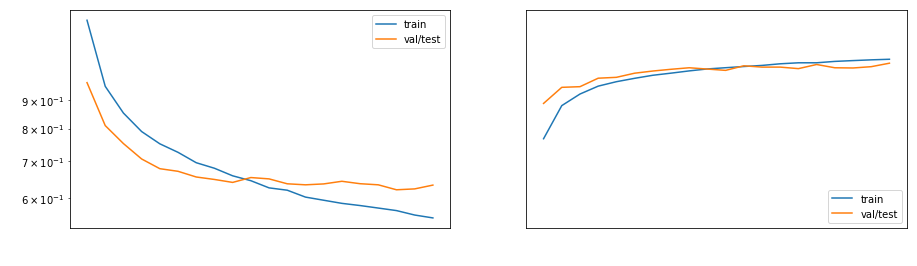

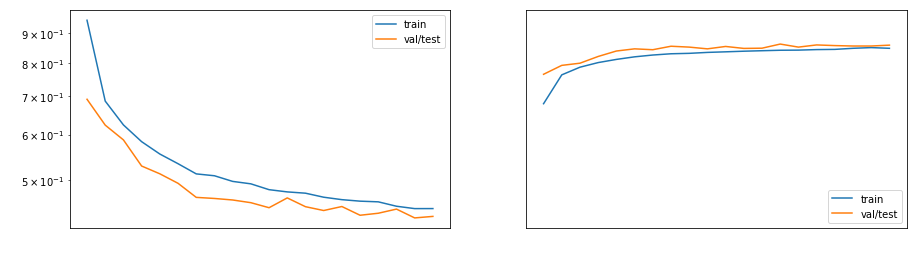

In [150]:
plot_loss_acc(hist)
plot_loss_acc(chist)